In [1]:
import numpy as np
import pandas as pd
import os
import glob
from glob import glob
import cv2
import re
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.utils import load_img, img_to_array

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda,Activation,Concatenate
from keras.models import Model

import warnings
warnings.filterwarnings("ignore")


# Підготовчий етап

## Провести аналіз вибраного набору даних, визначити вхідні та вихідні параметри, візуалізувати залежності входів на виходу, спробувати виявити основні залежності, детектувати аномалії, неповні зразки тощо у даних.

In [2]:
malignant = '/Users/Pavlo21/Downloads/Dataset_BUSI_with_GT/malignant/'
benign = '/Users/Pavlo21/Downloads/Dataset_BUSI_with_GT/benign/'

bening_cases = glob(benign+ '/*')
malignant_cases =glob(malignant+ '/*')


# An empty list. We will insert the data into this list in (img_path, mask_path) format
exclude=[]
train_data_mask = []
train_data_img=[]

# Go through all the bening cases. The label for these cases will be 1
for img in bening_cases:
    if img.endswith('_mask.png'):
        train_data_mask.append(img)
    elif img.endswith('_mask_1.png') or img.endswith('_mask_2.png'):
        exclude.append(img)
    else:
        train_data_img.append(img)

# Go through all the malignant cases. The label for these cases will be 1
for img in malignant_cases:

    if img.endswith('_mask.png'):
        train_data_mask.append(img)
    elif img.endswith('_mask_1.png') or img.endswith('_mask_2.png'):
        exclude.append(img)
    else:
        train_data_img.append(img)

print(len(exclude))
print(len(train_data_mask))
print(len(train_data_img))

train_data_img = sorted(train_data_img)
train_data_mask = sorted(train_data_mask)

import random

# Create index lists
index_list = list(range(len(train_data_img)))

# Shuffle index lists
random.shuffle(index_list)

# Create shuffled lists
shuffled_train_data_img = []
shuffled_train_data_mask = []

for i in index_list:
    shuffled_train_data_img.append(train_data_img[i])
    shuffled_train_data_mask.append(train_data_mask[i])

    
images=[]
masks=[]
size_x=128
size_y=128

for every_img_path in shuffled_train_data_img:
    img=cv2.imread(every_img_path,cv2.IMREAD_COLOR)
    img=cv2.resize(img,(size_y, size_x))
    img=img/255.0
    images.append(img)

for every_mask_path in shuffled_train_data_mask:
    mask=cv2.imread(every_mask_path,cv2.IMREAD_GRAYSCALE)
    mask=cv2.resize(mask,(size_y,size_x))
    mask=mask/255.0
    masks.append(mask)
    
images = np.array(images)
masks = np.array(masks)

print(np.shape(images))

18
647
647
(647, 128, 128, 3)


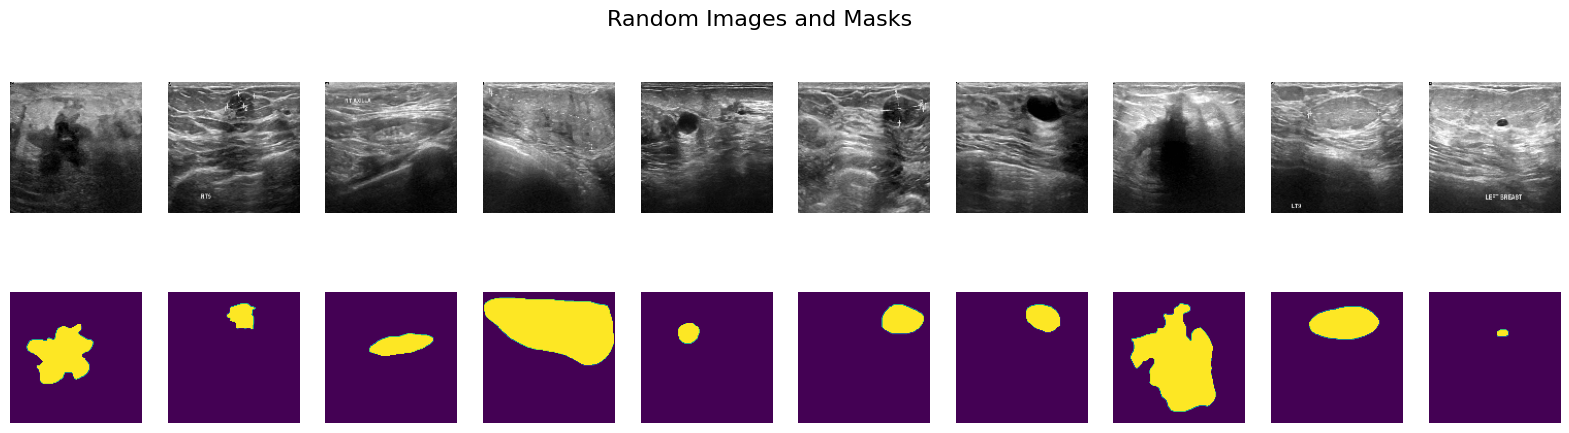

In [3]:
rand_indices = np.random.choice(len(images), 10, replace=False)
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 5))

for i, idx in enumerate(rand_indices):
    img = images[idx]
    mask = masks[idx]
    axes[0][i].imshow(img)
    axes[0][i].axis('off')
    axes[1][i].imshow(mask)
    axes[1][i].axis('off')
fig.suptitle('Random Images and Masks', fontsize=16)
plt.show()

In [4]:
batch=32
epochs=50

In [5]:
dataset=tf.data.Dataset.from_tensor_slices((images,masks))
train_data=dataset.take(500)
test_data=dataset.skip(500)

train_data=train_data.batch(batch)
train_data=train_data.prefetch(tf.data.AUTOTUNE)

test_data=test_data.batch(batch)
test_data=test_data.prefetch(tf.data.AUTOTUNE)


# UNET-Model

In [6]:
def conv_block(inputs,num_filters):
    x=Conv2D(num_filters,3,padding='same')(inputs)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)

    x=Conv2D(num_filters,3,padding='same')(x)
    x=Activation('relu')(x)

    return x

def encoder_block(inputs,num_filters):
    x=conv_block(inputs,num_filters)
    p=MaxPooling2D((2,2))(x)
    return x, p

def decoder_block(inputs,skip,num_filters):
    x=Conv2DTranspose(num_filters,(2,2),strides=(2,2),padding='same')(inputs)
    x=Concatenate()([x,skip])
    x=conv_block(x,num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)
    s1, p1 = encoder_block(inputs, 16)
    s2, p2 = encoder_block(p1, 32)
    s3, p3 = encoder_block(p2, 64)
    s4, p4 = encoder_block(p3, 128)

    b1 = conv_block(p4, 256)

    d1 = decoder_block(b1, s4, 128)
    d2 = decoder_block(d1, s3, 64)
    d3 = decoder_block(d2, s2, 32)
    d4 = decoder_block(d3, s1, 16)

    outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(d4)

    model = Model(inputs, outputs, name='UNET')
    return model



In [7]:
model_orig=build_unet((size_x,size_y,3))
model_orig.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                              

## Training on original dataset

In [8]:
opt=tf.keras.optimizers.Adam(0.001)
model_orig.compile(loss='binary_crossentropy',optimizer=opt,metrics=['acc'])

callbacks=[ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=4),
           EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=False)]

In [9]:
model_orig.fit(train_data,validation_data=test_data,epochs=epochs,callbacks=callbacks)

Epoch 1/50


2023-03-25 18:12:09.732524: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


16/16 [==============================] - 19s 1s/step - loss: 0.5151 - acc: 0.7603 - val_loss: 0.6034 - val_acc: 0.8981 - lr: 0.0010
Epoch 2/50
16/16 [==============================] - 16s 997ms/step - loss: 0.2439 - acc: 0.9079 - val_loss: 0.3619 - val_acc: 0.8981 - lr: 0.0010
Epoch 3/50
16/16 [==============================] - 15s 925ms/step - loss: 0.1914 - acc: 0.9080 - val_loss: 0.4095 - val_acc: 0.8981 - lr: 0.0010
Epoch 4/50
16/16 [==============================] - 15s 953ms/step - loss: 0.1768 - acc: 0.9081 - val_loss: 0.3812 - val_acc: 0.8981 - lr: 0.0010
Epoch 5/50
16/16 [==============================] - 16s 974ms/step - loss: 0.1643 - acc: 0.9093 - val_loss: 0.3284 - val_acc: 0.8981 - lr: 0.0010
Epoch 6/50
16/16 [==============================] - 16s 979ms/step - loss: 0.1594 - acc: 0.9199 - val_loss: 0.2813 - val_acc: 0.9033 - lr: 0.0010
Epoch 7/50
16/16 [==============================] - 16s 988ms/step - loss: 0.1489 - acc: 0.9382 - val_loss: 0.2789 - val_acc: 0.8931 - lr:

1/1 [==============================] - 0s 25ms/step


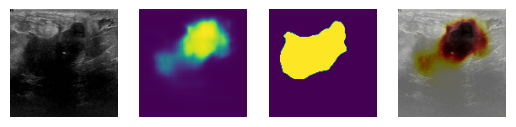

1/1 [==============================] - 0s 29ms/step


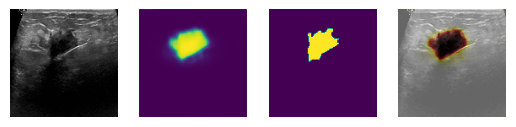

1/1 [==============================] - 0s 28ms/step


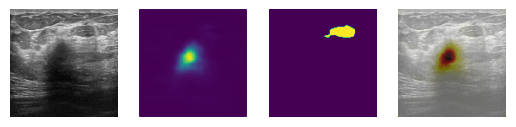

1/1 [==============================] - 0s 30ms/step


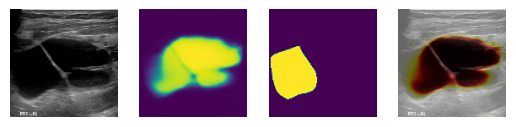

1/1 [==============================] - 0s 29ms/step


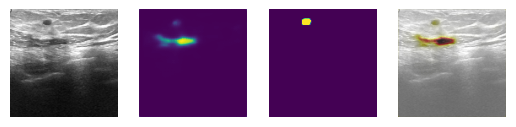

In [10]:
for x,y in test_data.take(5):
    plt.subplot(141),plt.imshow(x[0]),plt.axis('off')
    plt.subplot(142),plt.imshow(model_orig.predict(x[0][np.newaxis,:,:,:])[0]),plt.axis('off')
    plt.subplot(143),plt.imshow(y[0]),plt.axis('off')
    plt.subplot(144),plt.imshow(x[0]),plt.imshow(model_orig.predict(x[0][np.newaxis,:,:,:])[0],alpha=0.4,cmap='hot_r'),plt.axis('off')
    plt.show()

In [11]:
model_orig_result=model_orig.evaluate(test_data)
print(f'val_loss: {model_orig_result[0]}\nacc: {model_orig_result[1]}')

5/5 [==============================] - 1s 241ms/step - loss: 0.1573 - acc: 0.9473
val_loss: 0.1573275923728943
acc: 0.9473104476928711


## SRCNN Model

In [12]:
SRCNN_915=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,9,padding='same',activation='relu'),
    tf.keras.layers.Conv2D(64,1,padding='same',activation='relu'),
    tf.keras.layers.Conv2D(3,5,padding='same',activation='relu')
])
def pixel_mse_loss(y_true,y_pred):
  return tf.reduce_mean( (y_true - y_pred) ** 2 )
def PSNR(y_true,y_pred):
  mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
  return 20 * log10(1 / (mse ** 0.5))

def log10(x):
  numerator = tf.math.log(x)
  denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
  return numerator / denominator
SRCNN_915.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=pixel_mse_loss,metrics=['acc',PSNR])

In [13]:
def build_data(data):
  cropped = tf.dtypes.cast(tf.image.random_crop(data,(128,128,3)),tf.float32)
  lr=tf.image.resize(cropped,(64,64))
  lr=tf.image.resize(lr,(128,128), method = tf.image.ResizeMethod.BICUBIC)
  return (lr,cropped)

def downsample_image(image,scale):
  cropped = tf.dtypes.cast(tf.image.random_crop(image,(128,128,3)),tf.float32)
  lr=tf.image.resize(cropped,(image.shape[0]//scale,image.shape[1]//scale))
  lr=tf.image.resize(lr,(image.shape[0],image.shape[1]), method = tf.image.ResizeMethod.BICUBIC)
  return lr


In [14]:
train_srcnn_data=train_data.unbatch().map(lambda image,mask:build_data(image)).batch(batch)
test_srcnn_data=test_data.unbatch().map(lambda image,mask:build_data(image)).batch(batch)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Training on low quality dataset

In [15]:
SRCNN_915.fit(train_srcnn_data,validation_data=test_srcnn_data,epochs=epochs)

Epoch 1/50
16/16 [==============================] - 18s 1s/step - loss: 0.0250 - acc: 0.4240 - PSNR: 17.6267 - val_loss: 0.0108 - val_acc: 0.0227 - val_PSNR: 19.6973
Epoch 2/50
16/16 [==============================] - 17s 1s/step - loss: 0.0082 - acc: 0.3828 - PSNR: 20.8787 - val_loss: 0.0069 - val_acc: 0.1525 - val_PSNR: 21.6069
Epoch 3/50
16/16 [==============================] - 17s 1s/step - loss: 0.0059 - acc: 0.3188 - PSNR: 22.2766 - val_loss: 0.0051 - val_acc: 0.4245 - val_PSNR: 22.9660
Epoch 4/50
16/16 [==============================] - 17s 1s/step - loss: 0.0043 - acc: 0.3143 - PSNR: 23.6762 - val_loss: 0.0039 - val_acc: 0.2022 - val_PSNR: 24.1537
Epoch 5/50
16/16 [==============================] - 17s 1s/step - loss: 0.0034 - acc: 0.3187 - PSNR: 24.6392 - val_loss: 0.0034 - val_acc: 0.5423 - val_PSNR: 24.7529
Epoch 6/50
16/16 [==============================] - 17s 1s/step - loss: 0.0031 - acc: 0.3565 - PSNR: 25.0900 - val_loss: 0.0029 - val_acc: 0.3369 - val_PSNR: 25.4208
Epoc

In [16]:
SRCNN_915_result=SRCNN_915.evaluate(test_srcnn_data)
print(f'loss: {SRCNN_915_result[0]}')
print(f'acc: {SRCNN_915_result[1]}')
print(f'PSNR: {SRCNN_915_result[2]}')

5/5 [==============================] - 1s 228ms/step - loss: 0.0019 - acc: 0.3562 - PSNR: 27.1376
loss: 0.001946528092958033
acc: 0.3561970293521881
PSNR: 27.13763427734375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


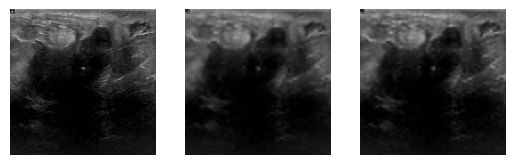

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


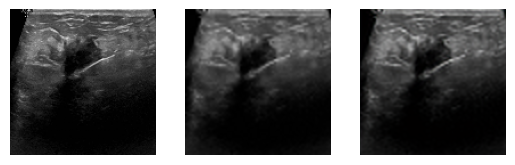

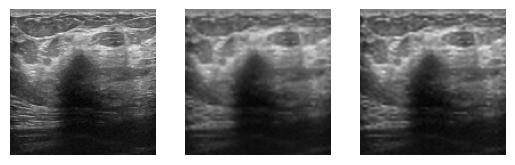

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


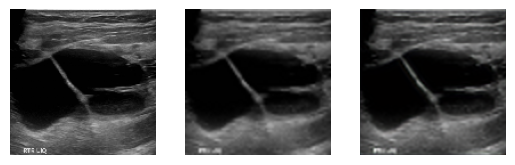

In [17]:
for x,y in test_data.take(4):
    plt.subplot(131),plt.imshow(x[0]),plt.axis('off');
    plt.subplot(132),plt.imshow(downsample_image(x[0],2)),plt.axis('off');
    plt.subplot(133),plt.imshow(SRCNN_915(downsample_image(x[0],2)[np.newaxis,:,:,:])[0]),plt.axis('off');
    plt.show()

In [18]:
lq_train_data=train_data.unbatch().map(lambda image,mask:(downsample_image(image,2),mask))
lq_test_data=test_data.unbatch().map(lambda image,mask:(downsample_image(image,2),mask))
upscaled_train=lq_train_data.map(lambda image,mask:(SRCNN_915(image[np.newaxis,:,:,:])[0],mask)).batch(batch)
upscaled_test=lq_test_data.map(lambda image,mask:(SRCNN_915(image[np.newaxis,:,:,:])[0],mask)).batch(batch)
lq_train_data=lq_train_data.batch(32)
lq_test_data=lq_test_data.batch(32)

In [19]:
lq_unet=build_unet((size_x,size_y,3))
upscaled_unet=build_unet((size_x,size_y,3))

In [20]:
opt=tf.keras.optimizers.Adam(0.001)
lq_unet.compile(loss='binary_crossentropy',optimizer=opt,metrics=['acc'])

callbacks=[ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=4),
           EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=False)]

lq_unet.fit(lq_train_data,validation_data=lq_test_data,epochs=epochs,callbacks=callbacks)

Epoch 1/50
16/16 [==============================] - 21s 1s/step - loss: 0.3406 - acc: 0.8951 - val_loss: 0.5192 - val_acc: 0.8981 - lr: 0.0010
Epoch 2/50
16/16 [==============================] - 19s 1s/step - loss: 0.2052 - acc: 0.9079 - val_loss: 0.2893 - val_acc: 0.8981 - lr: 0.0010
Epoch 3/50
16/16 [==============================] - 19s 1s/step - loss: 0.1875 - acc: 0.9079 - val_loss: 0.3432 - val_acc: 0.8981 - lr: 0.0010
Epoch 4/50
16/16 [==============================] - 19s 1s/step - loss: 0.1737 - acc: 0.9079 - val_loss: 0.2619 - val_acc: 0.8981 - lr: 0.0010
Epoch 5/50
16/16 [==============================] - 19s 1s/step - loss: 0.1603 - acc: 0.9079 - val_loss: 0.3022 - val_acc: 0.8981 - lr: 0.0010
Epoch 6/50
16/16 [==============================] - 19s 1s/step - loss: 0.1529 - acc: 0.9079 - val_loss: 0.3910 - val_acc: 0.8981 - lr: 0.0010
Epoch 7/50
16/16 [==============================] - 19s 1s/step - loss: 0.1504 - acc: 0.9079 - val_loss: 0.3482 - val_acc: 0.8982 - lr: 0.0010

In [22]:
opt=tf.keras.optimizers.Adam(0.001)
upscaled_unet.compile(loss='binary_crossentropy',optimizer=opt,metrics=['acc'])

callbacks=[ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=4),
           EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=False)]

upscaled_unet.fit(upscaled_train,validation_data=upscaled_test,epochs=epochs,callbacks=callbacks)

Epoch 1/50
16/16 [==============================] - 29s 2s/step - loss: 0.2601 - acc: 0.9079 - val_loss: 0.4758 - val_acc: 0.8981 - lr: 0.0010
Epoch 2/50
16/16 [==============================] - 27s 2s/step - loss: 0.2008 - acc: 0.9144 - val_loss: 0.5293 - val_acc: 0.8981 - lr: 0.0010
Epoch 3/50
16/16 [==============================] - 27s 2s/step - loss: 0.1772 - acc: 0.9331 - val_loss: 0.5675 - val_acc: 0.7306 - lr: 0.0010
Epoch 4/50
16/16 [==============================] - 27s 2s/step - loss: 0.1610 - acc: 0.9394 - val_loss: 0.4260 - val_acc: 0.8340 - lr: 0.0010
Epoch 5/50
16/16 [==============================] - 27s 2s/step - loss: 0.1462 - acc: 0.9444 - val_loss: 0.4091 - val_acc: 0.8010 - lr: 0.0010
Epoch 6/50
16/16 [==============================] - 28s 2s/step - loss: 0.1318 - acc: 0.9486 - val_loss: 0.2695 - val_acc: 0.8989 - lr: 0.0010
Epoch 7/50
16/16 [==============================] - 28s 2s/step - loss: 0.1191 - acc: 0.9531 - val_loss: 0.3682 - val_acc: 0.8980 - lr: 0.0010

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 209ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 24ms/step


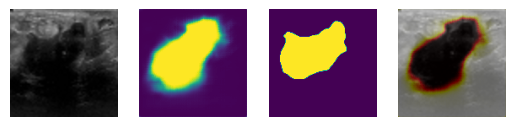

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 28ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 48ms/step


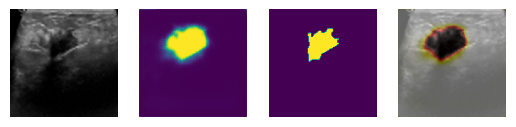

1/1 [==============================] - 0s 25ms/step


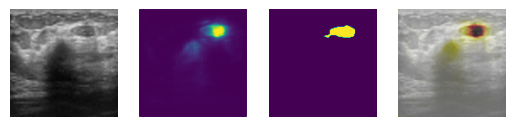

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 22ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 22ms/step


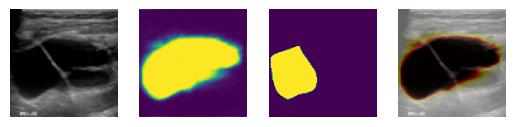

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 27ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 30ms/step


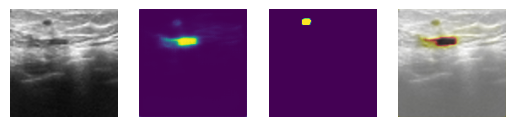

In [23]:
for x,y in lq_test_data.take(5):
    plt.subplot(141),plt.imshow(x[0]),plt.axis('off')
    plt.subplot(142),plt.imshow(lq_unet.predict(x[0][np.newaxis,:,:,:])[0]),plt.axis('off')
    plt.subplot(143),plt.imshow(y[0]),plt.axis('off')
    plt.subplot(144),plt.imshow(x[0]),plt.imshow(lq_unet.predict(x[0][np.newaxis,:,:,:])[0],alpha=0.4,cmap='hot_r'),plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 26ms/step


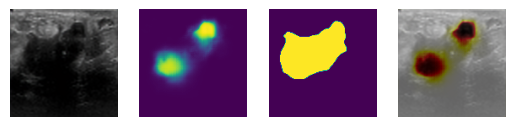

1/1 [==============================] - 0s 25ms/step


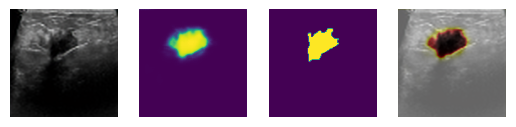

1/1 [==============================] - 0s 29ms/step


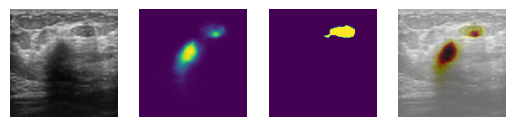

1/1 [==============================] - 0s 28ms/step


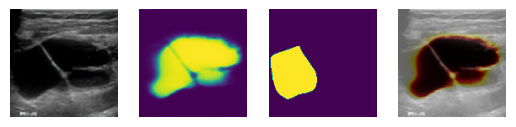

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 23ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 22ms/step


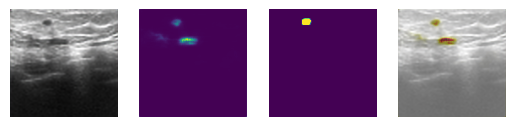

In [24]:
for x,y in upscaled_test.take(5):
    plt.subplot(141),plt.imshow(x[0]),plt.axis('off')
    plt.subplot(142),plt.imshow(upscaled_unet.predict(x[0][np.newaxis,:,:,:])[0]),plt.axis('off')
    plt.subplot(143),plt.imshow(y[0]),plt.axis('off')
    plt.subplot(144),plt.imshow(x[0]),plt.imshow(upscaled_unet.predict(x[0][np.newaxis,:,:,:])[0],alpha=0.4,cmap='hot_r'),plt.axis('off')
    plt.show()

In [25]:
model_orig_result=model_orig.evaluate(test_data)
lq_unet_result=lq_unet.evaluate(lq_test_data)
upscaled_unet_result=upscaled_unet.evaluate(upscaled_test)

5/5 [==============================] - 4s 681ms/step - loss: 0.1669 - acc: 0.9461


In [26]:
import pandas as pd

pd.DataFrame(columns=['val_loss','acc'],index=['orig_data','lq_data','upscale_data'],data=[[model_orig_result[0],model_orig_result[1]],
                                                                                           [lq_unet_result[0],lq_unet_result[1]],
                                                                                           [upscaled_unet_result[0],upscaled_unet_result[1]]])

,val_loss,acc
orig_data,0.157328,0.947310
lq_data,0.171341,0.942264
upscale_data,0.166855,0.946073
